In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.path as mpath
from matplotlib.colors import LogNorm
import plotly.express as px
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator, CubicSpline, interp1d, PchipInterpolator
from scipy.spatial import Delaunay
import os
import json
from tqdm import tqdm
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
import json

In [3]:
# def loadData(filePath):
#     with open(filePath, 'r') as f:
#         data = json.load(f)
    
#     keys_single = ['nodes', 'elements', 'solution', 'elementsBoundaryNodesOnly','areaElementsBoundaryNodesOnly','distance2boundary','elSizeNodes']
#     for i in tqdm(range(len(data))):
#         for key in data[i].keys():
#             if key in keys_single:
#                 data[i][key] = np.array(data[i][key])
#             else:
#                 for j in range(len(data[i][key])):
#                     if type(data[i][key][j]) == list:
#                         data[i][key][j] = np.array(data[i][key][j])
#     return data

class IsInDomain:
    def __init__(self, nodesCurves):
        self.loops = [mpath.Path(nodesCurves[i]) for i in range(len(nodesCurves))]
        
    def __call__(self, points):
        return np.logical_and(self.loops[0].contains_points(points),np.logical_not(np.array([loop.contains_points(points) for loop in self.loops[1:]]).any(0)))

class Interp2DInDomain:
    def __init__(self,points,vals,isInDomainF,kind='cubic'):
        if kind == 'cubic':
            self.interpF = CloughTocher2DInterpolator(points,vals)
        elif kind == 'linear':
            self.interpF = LinearNDInterpolator(points,vals)
        else:
            raise ValueError("kind must be either 'cubic' or 'linear'")
        self.inInDomainF = isInDomainF
        self.nDims = vals.shape[-1]
    
    def __call__(self,points):
        vals = self.interpF(points)
        vals[~self.inInDomainF(points)] = np.nan
        return vals
    
class Interp1DPeriodic:
    def __init__(self, x, y, kind = 'linear'):
        self.x = x
        self.y = y
        self.kind = kind
        self.spline = interp1d(self.x,self.y,kind=self.kind,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
class Interp1DPchipPeriodic:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.spline = PchipInterpolator(self.x,self.y,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
def addInterpF2Data(data):
    valSliceE = slice(0,3)
    valSliceD = slice(0,2)

    data['isInDomainF'] = IsInDomain(data['nodesCurves'])
    data['interpSE'] = Interp2DInDomain(data['nodes'],data['solution'][:,valSliceE],data['isInDomainF'])
    data['interpSD'] = Interp2DInDomain(data['nodes'],data['solution'][:,valSliceD],data['isInDomainF'])
    data['interpD2B'] = Interp2DInDomain(data['nodes'],data['distance2boundary'],data['isInDomainF'],kind='linear')
    data['interpELS'] = Interp2DInDomain(data['nodes'],data['elSizeNodes'],data['isInDomainF'],kind='linear')

    data['solutionB'] = []
    data['interpBS'] = []
    data['interpBN'] = []
    data['interpBC'] = []
    for i in range(len(data['idxCurves'])):
        data['solutionB'].append(data['solution'][data['idxCurves'][i]])
        data['interpBS'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['solutionB'][i]))
        data['interpBN'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['normalCurves'][i]))
        data['interpBC'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['nodesCurves'][i]))

def addElementSize2Data(data):
    nodes = data['nodes']
    elements = data['elements']
    areaElements = GetAreaTriang(nodes[elements])[:,0,0]
    areaNodes = np.zeros(nodes.shape[0])
    countNodes = np.zeros(nodes.shape[0])
    for i,el in enumerate(elements):
        areaNodes[el] += areaElements[i]
        countNodes[el] += 1

    countNodes[countNodes == 0] = np.inf
    areaNodes /= countNodes
    areaNodes = areaNodes.reshape(-1,1)
    elSizeNodes = 2/(3**0.25)*np.sqrt(areaNodes)
    data['elSizeNodes'] = elSizeNodes

def GetAreaTriang(nodes_els):
    # Calculate the area of a triangles in a mesh
    #   nodes_els - [N,3,2] tensor which containes the x,y positions of nodes of N triangles
    b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
    c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
    Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
    return Area

def loadData(filePath):
    with open(filePath, 'r') as f:
        data = json.load(f)
    data = data[:100]

    keys_single = ['nodes', 'elements', 'solution', 'elementsBoundaryNodesOnly','areaElementsBoundaryNodesOnly','distance2boundary','elSizeNodes']
    for i in tqdm(range(len(data))):
    # for i in tqdm(range(100)):
        for key in data[i].keys():
            if key in keys_single:
                data[i][key] = np.array(data[i][key])
            else:
                for j in range(len(data[i][key])):
                    if type(data[i][key][j]) == list:
                        data[i][key][j] = np.array(data[i][key][j])
        addInterpF2Data(data[i])
        data[i]['area'] = GetAreaTriang(data[i]['nodes'][data[i]['elements']])
    return data

data_arr = loadData('TrainingData/LowReFlowDataProcessed/dataLowReFLow2.json')

In [27]:
for data_i in tqdm(data_arr):
    nodesCurves = data_i['nodesCurves']
    normalCurves = data_i['normalCurves']
    interpSE = data_i['interpSE']
    valsCurves = data_i['solutionB']

    derL = 0.1
    nodesCurvesOffset = [nodesCurves[i] - derL*normalCurves[i] for i in range(len(nodesCurves))]
    valsCurvesOffset = [interpSE(nodesCurvesOffset[i]) for i in range(len(nodesCurves))]
    data_i['solutionBoffset'] = valsCurvesOffset

100%|██████████| 3973/3973 [00:52<00:00, 74.99it/s]


In [46]:
data_i[key_del[0]]

In [47]:
data_arr_list = data_arr.copy()

for i in tqdm(range(len(data_arr_list))):
    data = data_arr_list[i]
    key_del = ['isInDomainF','interpSE','interpSD','interpD2B','interpELS','interpBS','interpBN','interpBC']
    for key in key_del:
        if key in data.keys():
            del data[key]
    for key in data.keys():
        if type(data[key]) == np.ndarray:
            data[key] = data[key].tolist()
        elif type(data[key]) == list:
            if type(data[key][0]) == np.ndarray:
                for j in range(len(data[key])):
                    data[key][j] = data[key][j].tolist()
            elif type(data[key][0]) == np.int64:
                data[key] = [int(x) for x in data[key]]

# write to a json file
with open('TrainingData/LowReFlowDataProcessed/dataLowReFLow3.json', 'w') as f:
    json.dump(data_arr_list, f)

100%|██████████| 3973/3973 [01:01<00:00, 64.32it/s] 


In [43]:
data_i = data_arr[301]
nodesCurves = data_i['nodesCurves']
normalCurves = data_i['normalCurves']
interpSE = data_i['interpSE']
valsCurves = data_i['solutionB']
valsCurvesOffset = data_i['solutionBoffset']

# derL = 0.1
# nodesCurvesOffset = [nodesCurves[i] - derL*normalCurves[i] for i in range(len(nodesCurves))]
# valsCurvesOffset = [interpSE(nodesCurvesOffset[i]) for i in range(len(nodesCurves))]
# derivNormCurves = [(valsCurves[i] - valsCurvesOffset[i])/derL for i in range(len(valsCurvesOffset))]

# for i in range(len(nodesCurves)):
#     plt.plot(nodesCurves[i][:,0],nodesCurves[i][:,1],'k')
#     plt.plot(nodesCurvesOffset[i][:,0],nodesCurvesOffset[i][:,1],'r')

(array([[  0.,   0.,   0.,   0.,  84.,  82.,  51.,  49.,  10.,   0.],
        [  0.,  13.,  20.,  15., 159.,  33.,  36.,   0.,   0.,   0.],
        [ 40., 114.,  13.,  10.,  11.,  11.,  13.,  13.,  16.,  35.]]),
 array([-0.66219734, -0.5135257 , -0.36485407, -0.21618244, -0.06751081,
         0.08116083,  0.22983246,  0.37850409,  0.52717572,  0.67584735,
         0.82451899]),
 <a list of 3 BarContainer objects>)

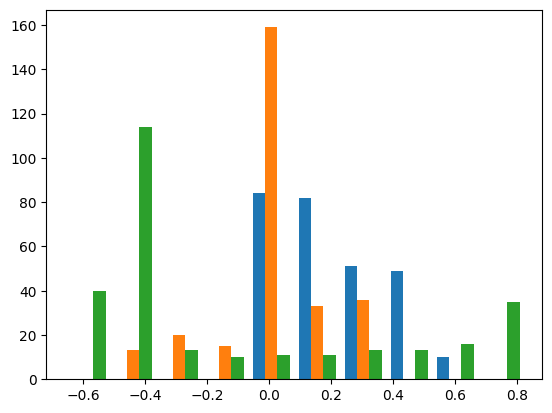

In [39]:
plt.hist(valsCurvesOffset[1])

In [8]:
def GetB_el_triang(nodes,r):
    b = np.roll(nodes[:,1],1) - np.roll(nodes[:,1],2)
    c = np.roll(nodes[:,0],2) - np.roll(nodes[:,0],1)
    Area = np.abs(np.dot(nodes[:,0],b))/2
    Bx = np.concatenate([b[i]*np.eye(r) for i in range(3)],1)/(2*Area)
    By = np.concatenate([c[i]*np.eye(r) for i in range(3)],1)/(2*Area)
    return Bx, By, Area


data_i = data_arr[0]
nodes = data_i['nodes']
elements = data_i['elements']
u = data_i['solution']
r = u.shape[-1]

gradX_nodes = np.zeros((nodes.shape[0],r))
gradY_nodes = np.zeros((nodes.shape[0],r))
area_nodes = np.zeros((nodes.shape[0]))
for el in elements:
    Bx, By, Area = GetB_el_triang(nodes[el],r)
    u_el_flat = u[el].flatten()
    gradX_el = np.dot(Bx,u_el_flat)
    gradY_el = np.dot(By,u_el_flat)
    gradX_nodes[el] += gradX_el * Area
    gradY_nodes[el] += gradY_el * Area
    area_nodes[el] += Area

area_nodes[area_nodes == 0] = 1
gradX_nodes /= area_nodes[:,None]
gradY_nodes /= area_nodes[:,None]


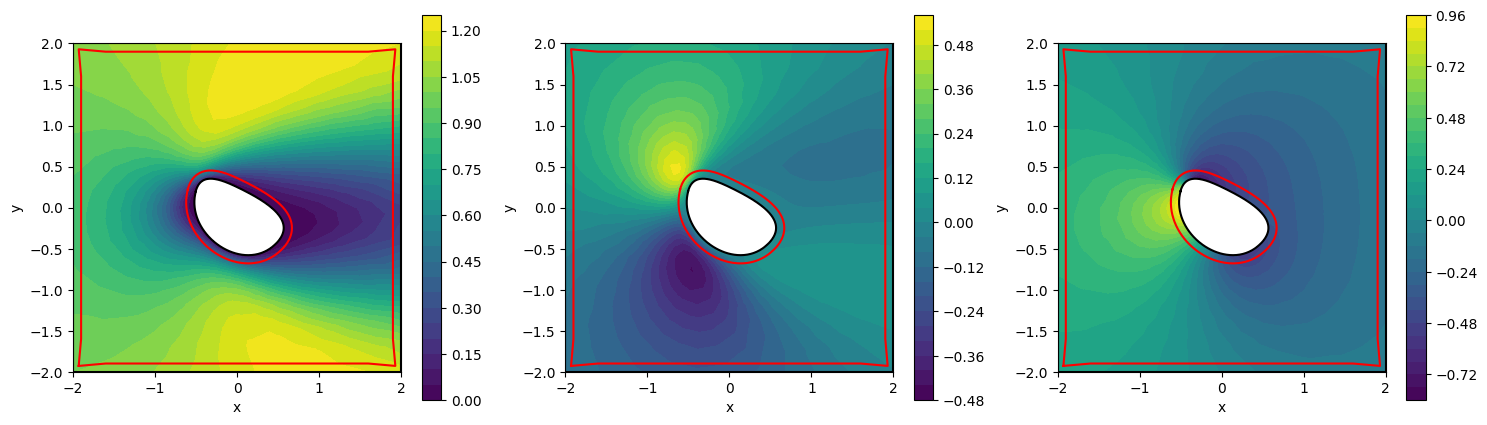

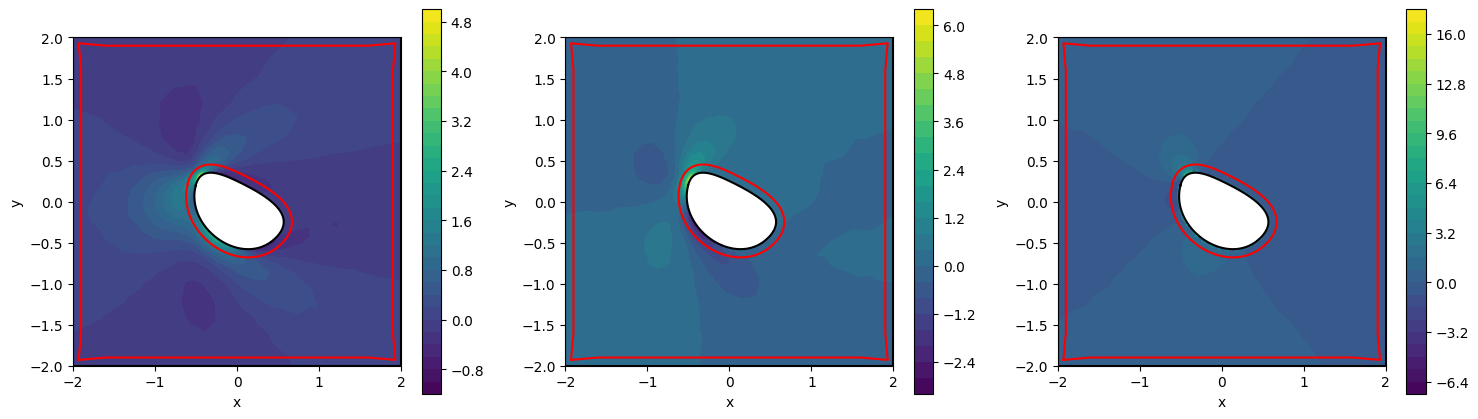

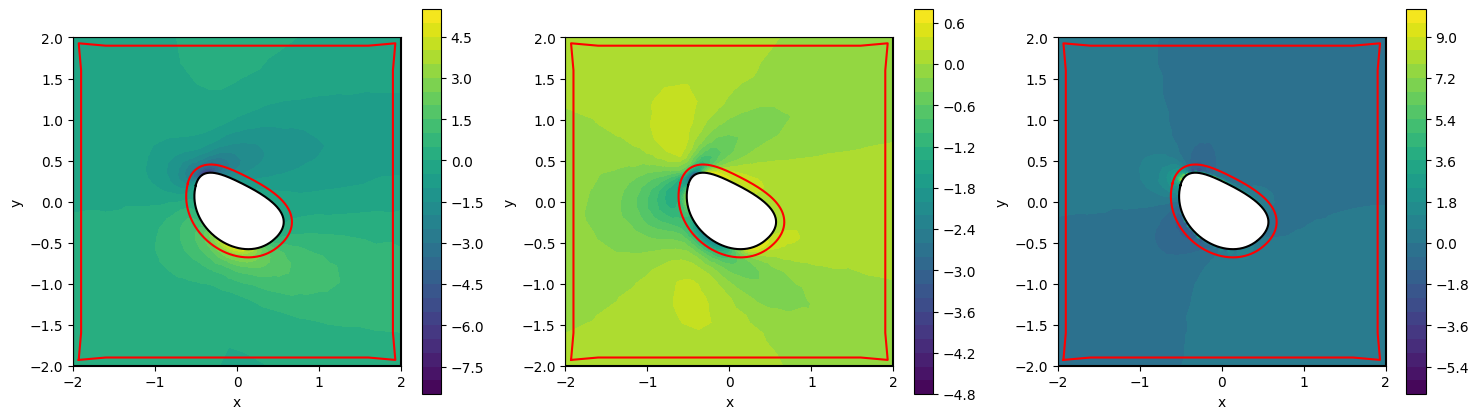

In [12]:
def PlotFEMsolution(nodes, elements,l):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    n_rows = np.ceil(r/3).astype(int)
    n_cols = min(r,3)
    plt.figure(figsize=(6*n_cols,5*n_rows))
    for i in range(r):
        plt.subplot(n_rows,n_cols,i+1)
        plt.tricontourf(triangulation, l[:,i],30)
        plt.colorbar()
        # plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
        for i in range(len(nodesCurves)):
            plt.plot(nodesCurves[i][:,0],nodesCurves[i][:,1],'k')
            plt.plot(nodesCurvesOffset[i][:,0],nodesCurvesOffset[i][:,1],'r')
    plt.show()
    return

%matplotlib inline
PlotFEMsolution(nodes, elements,u)
PlotFEMsolution(nodes, elements,gradX_nodes)
PlotFEMsolution(nodes, elements,gradY_nodes)

In [7]:
nodes[elements].shape

(3411, 3, 2)

In [26]:
def point_to_line_segment_distance(p, a, b):
    # p is the point, a and b are the endpoints of the line segment
    # Convert points to numpy arrays for vector operations
    p, a, b = np.array(p), np.array(a), np.array(b)
    # Calculate vectors
    ap = p - a
    ab = b - a
    # Calculate the magnitude of ab
    ab_magnitude = np.linalg.norm(ab)
    # Calculate the dot product
    dot_product = np.dot(ap, ab) / (ab_magnitude**2)
    # Find the projection's distance along the segment
    distance_along_segment = min(max(dot_product, 0), 1)
    # Calculate the closest point on the segment
    closest_point = a + distance_along_segment * ab
    # Return the distance from p to the closest point
    return np.linalg.norm(p - closest_point)

def distance_point_to_polygon(point, polygon):
    min_distance = float('inf')
    for i in range(len(polygon) - 1):
        segment_distance = point_to_line_segment_distance(point, polygon[i], polygon[i+1])
        min_distance = min(min_distance, segment_distance)
    return min_distance

def distance_point_boundary(point, boundaryNodes):
    min_distance = np.inf
    for i in range(len(boundaryNodes)):
        polygon_distance = distance_point_to_polygon(point, boundaryNodes[i])
        min_distance = min(min_distance, polygon_distance)
    return min_distance

def GetDistanceToBoundary(nodes, internalNodes, boundaryNodes):
    distance2boundaryNodes = np.zeros(nodes.shape[0])
    for i in internalNodes:
        distance2boundaryNodes[i] = distance_point_boundary(nodes[i], boundaryNodes)
    return distance2boundaryNodes.reshape(-1,1)

for data in tqdm(data_arr[2:3]):
    nodes = data['nodes']
    elements = data['elements']
    boundaryNodes = data['nodesCurves'].copy()
    idxCurves = np.concatenate([dc[:-1] for dc in data['idxCurves']],0)
    internalNodes = np.setdiff1d(np.unique(elements),idxCurves)
    data['distance2boundary'] = GetDistanceToBoundary(nodes, internalNodes, boundaryNodes)

100%|██████████| 1/1 [00:06<00:00,  6.09s/it]


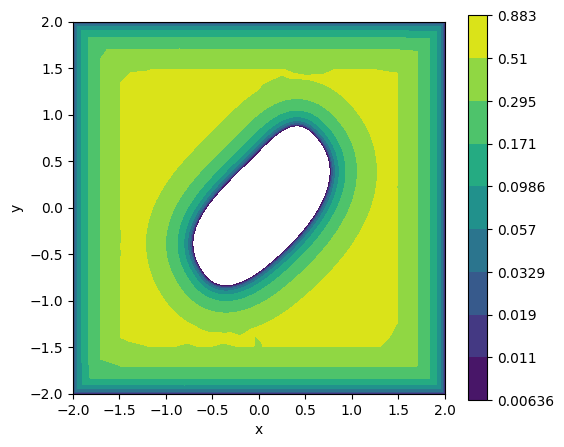

In [68]:
def PlotFEMsolution(nodes, elements,l,n_levels=10,cmapLog=False,cmap='viridis'):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    plt.figure(figsize=(6*r,5))
    for i in range(r):
        plt.subplot(1,r,i+1)
        if cmapLog:
            levels = np.logspace(np.log10(l[:,i].min()),np.log10(l[:,i].max()),n_levels)
            plt.tricontourf(triangulation, l[:,i],levels,cmap=cmap,norm=LogNorm(l[:,i].min(),l[:,i].max()))
            cbar = plt.colorbar()
            cbar_ticks = np.logspace(np.log10(levels.min()), np.log10(levels.max()), num=10)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(["{:.3g}".format(i) for i in cbar_ticks])
        else:
            plt.tricontourf(triangulation, l[:,i],n_levels,cmap=cmap)
            plt.colorbar()
        # plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
    return

data = data_arr[100]
nodes = data['nodes']
elements = data['elements']
idxCurves = np.concatenate([dc[:-1] for dc in data['idxCurves']],0)
internalNodes = np.setdiff1d(np.unique(elements),idxCurves)
distance2boundary = data['distance2boundary'].copy()
distance2boundary[distance2boundary == 0] = distance2boundary[internalNodes].min()
%matplotlib inline
PlotFEMsolution(nodes, elements,distance2boundary,cmapLog=True)

In [43]:
def GetAreaTriang(nodes_els):
    # Calculate the area of a triangles in a mesh
    #   nodes_els - [N,3,2] tensor which containes the x,y positions of nodes of N triangles
    b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
    c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
    Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
    return Area

def addElementSize2Data(data):
    nodes = data['nodes']
    elements = data['elements']
    areaElements = GetAreaTriang(nodes[elements])[:,0,0]
    areaNodes = np.zeros(nodes.shape[0])
    countNodes = np.zeros(nodes.shape[0])
    for i,el in enumerate(elements):
        areaNodes[el] += areaElements[i]
        countNodes[el] += 1

    countNodes[countNodes == 0] = np.inf
    areaNodes /= countNodes
    areaNodes = areaNodes.reshape(-1,1)
    elSizeNodes = 2/(3**0.25)*np.sqrt(areaNodes)
    data['elSizeNodes'] = elSizeNodes

for data in tqdm(data_arr):
    addElementSize2Data(data)

100%|██████████| 3973/3973 [00:26<00:00, 152.70it/s]


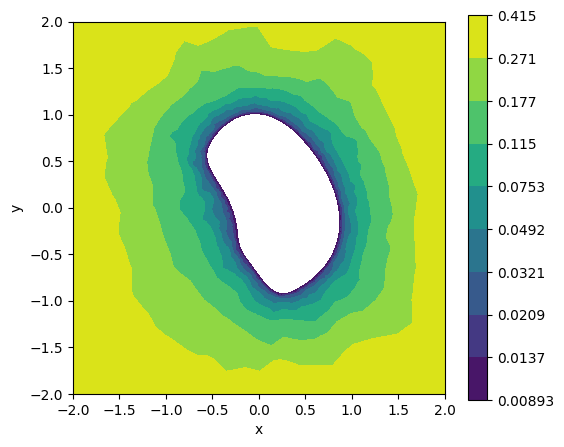

In [69]:
data = data_arr[2001]
nodes = data['nodes']
elements = data['elements']
elSizeNodes = data['elSizeNodes'].copy()
elSizeNodes[elSizeNodes == 0] = elSizeNodes.max()
%matplotlib inline
# %matplotlib qt
PlotFEMsolution(nodes, elements,elSizeNodes,cmapLog=True)

In [19]:
def GetAreaTriang(nodes_els):
    # Calculate the area of a triangles in a mesh
    #   nodes_els - [N,3,2] tensor which containes the x,y positions of nodes of N triangles
    b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
    c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
    Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
    return Area

def RandomTriangSample(nodes):
    # Sample a random points inside a trinagle defined by [3,2] matrix: nodes
    y = np.random.uniform()
    x = np.abs(np.random.uniform()-np.random.uniform())
    p = nodes[1] + (nodes[0]-nodes[1])*x - (nodes[1]-nodes[2])*(1-x)*y
    return p

def RandomMeshSample(nodes,elements,Area=None):
    # Sample a random point from a 2D shape defined with a mesh: (nodes, elements)
    if Area is None:
        Area = GetAreaTriang(nodes[elements]).flatten()
    el_sample = np.random.choice(np.arange(elements.shape[0]),p=Area/Area.sum())
    point_sample = RandomTriangSample(nodes[elements[el_sample]])
    return point_sample

In [29]:
for data in tqdm(data_arr):
    nodesBMesh = np.concatenate(data['nodesCurves'])
    idxNodesBMesh = np.concatenate(data['idxCurves'])
    tri = Delaunay(nodesBMesh)
    triangles = tri.simplices

    idx_pick = np.logical_not((triangles>len(data['nodesCurves'][0])-1).all(1))
    triangles = triangles[idx_pick]

    triangles = idxNodesBMesh[triangles]
    data['elementsBoundaryNodesOnly'] = triangles

    area = GetAreaTriang(data['nodes'][triangles]).flatten()
    data['areaElementsBoundaryNodesOnly'] = area

100%|██████████| 3973/3973 [00:04<00:00, 975.65it/s] 


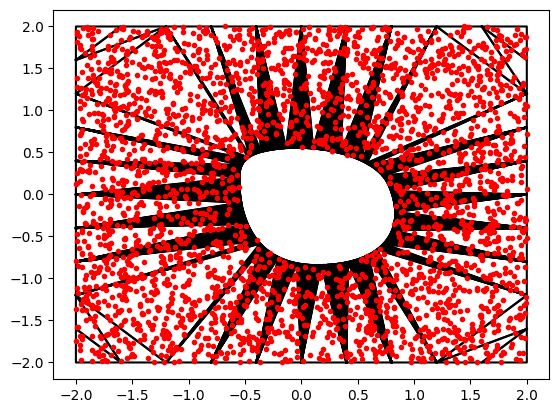

In [21]:
i = 2000
data = data_arr[i]


nodes = data['nodes']
triangles = data['elementsBoundaryNodesOnly']
area = data['areaElementsBoundaryNodesOnly']
n_samples = 3000
samples = np.zeros((n_samples,2))
for i in range(n_samples):
    samples[i] = RandomMeshSample(nodes,triangles,area)

for triangle in triangles:
    plt.plot(nodes[triangle[[0,1,2,0]],0], nodes[triangle[[0,1,2,0]],1], 'k-')

plt.plot(samples[:,0],samples[:,1],'r.')

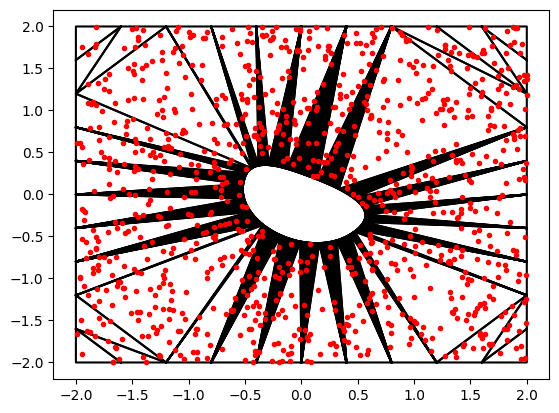

In [27]:
data = data_arr[0]

nodesMesh = np.concatenate(data['nodesCurves'])
idxNodesMesh = np.concatenate(data['idxCurves'])
n_edges = np.cumsum([len(curve) for curve in (data['nodesCurves'])])
tri = Delaunay(nodesMesh)
triangles = tri.simplices

idx_pick = np.logical_not((triangles>len(data['nodesCurves'][0])-1).all(1))
triangles = triangles[idx_pick]

triangles = idxNodesMesh[triangles]

nodes = data['nodes']
for triangle in triangles:
    plt.plot(nodes[triangle[[0,1,2,0]],0], nodes[triangle[[0,1,2,0]],1], 'k-')

area = GetAreaTriang(nodes[triangles])
n_samples = 1000
samples = np.zeros((n_samples,2))
for i in range(n_samples):
    samples[i] = RandomMeshSample(nodes,triangles,area)

plt.plot(samples[:,0],samples[:,1],'r.')



# plt.figure(figsize=(10,10))
# plt.triplot(nodesMesh[:,0], nodesMesh[:,1], triangles)
# plt.xlim([-1,0])
# plt.ylim([0,0.5])

In [24]:
area.shape

(353, 1, 1)

In [33]:
keys = ['nodes', 'elements', 'edges', 'flow']
data_files = {}

for key in keys:
    files = os.listdir('TrainingData/LowReFlowData/dataset_shapes_gcnn/' + key + '/')
    files = [f for f in files if f.endswith('.csv')]
    code = [int(f.split('_')[1].split('.')[0]) for f in files]
    data_files[key+'_files'] = files
    data_files[key+'_code'] = code

In [35]:
dataO = []

# for i in tqdm(range(len(data_files['nodes_files']))):
for i in tqdm(range(10)):
    nodes = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/nodes/' + data_files['nodes_files'][i])
    elements = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/elements/' + data_files['elements_files'][i])
    edges = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/edges/' + data_files['edges_files'][i])
    flow = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/flow/' + data_files['flow_files'][i])
    dataO.append({'nodes':nodes, 'elements':elements, 'edges':edges, 'flow':flow})

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 46.21it/s]


In [47]:
nodes = dataO[0]['nodes']
elements = dataO[0]['elements']
flow = dataO[0]['flow']

PlotFEMsolution(nodes.to_numpy(), elements.to_numpy(), flow.to_numpy())

,u,v,p
0,0.999047,-0.089737,0.203542
1,1.172269,-0.003814,-0.090885
2,1.198277,-0.003325,-0.095173
3,1.026955,0.107972,0.150112
4,0.010565,0.024896,0.688316
...,...,...,...
1933,0.138360,-0.028462,-0.606769
1934,0.025229,-0.010748,-0.403384
1935,0.205278,-0.040550,-0.355361
1936,0.006056,-0.007732,-0.356518


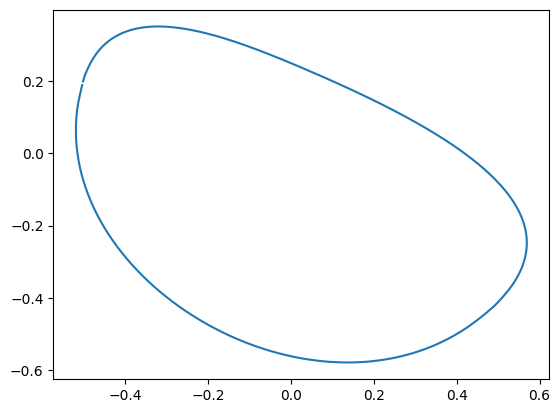

In [16]:
nodes = dataO[0]['nodes']
flow = dataO[0]['flow']
nodesB = nodes[nodes['Object']==0.0]
flowB = flow.iloc[nodesB.index]
plt.plot(nodesB['x'],nodesB['y'])

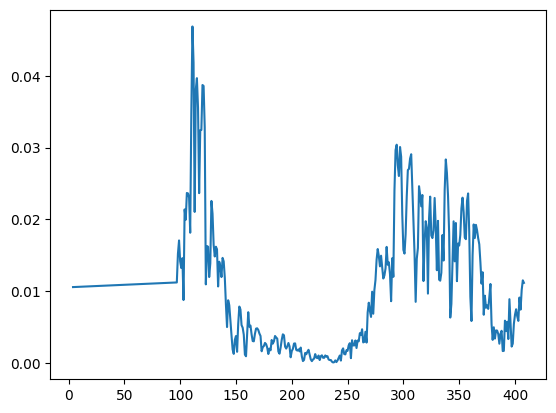

In [19]:
plt.plot(flowB['u'])

In [15]:
dataO[0].keys()

dict_keys(['nodes', 'elements', 'edges', 'flow'])

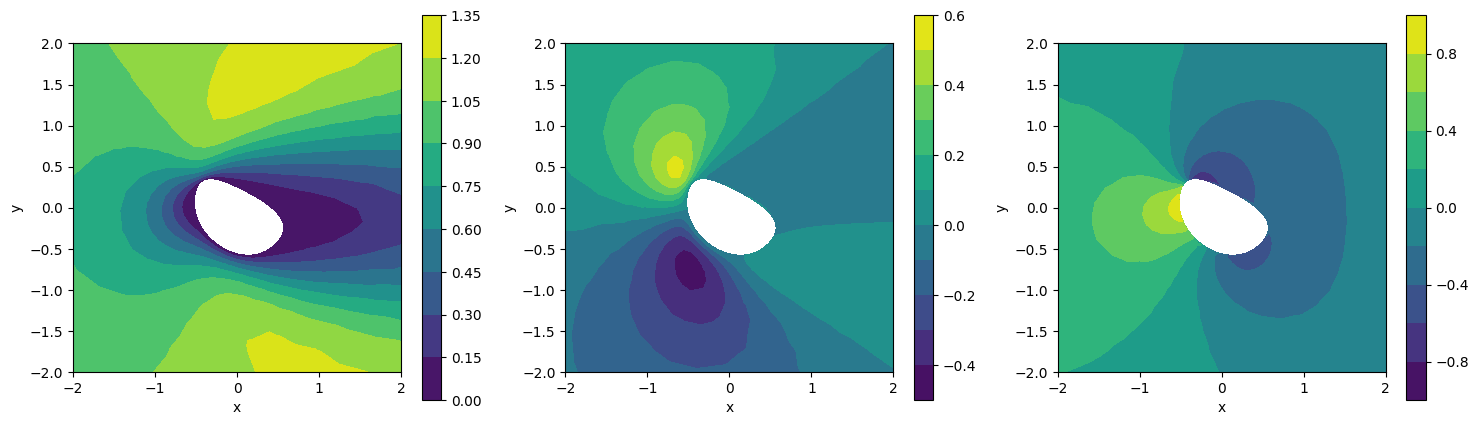

In [9]:
def PlotFEMsolution(nodes, elements,l):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    plt.figure(figsize=(6*r,5))
    for i in range(r):
        plt.subplot(1,r,i+1)
        plt.tricontourf(triangulation, l[:,i],10)
        plt.colorbar()
        # plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
    return 

PlotFEMsolution(dataO[0]['nodes'].values, dataO[0]['elements'].values, dataO[0]['flow'].values)

In [506]:
def computeLengthAlongCurve(nodesB):
    dl = np.sqrt(((nodesB[1:]-nodesB[:-1])**2).sum(1))
    l = np.cumsum(dl)
    l = np.concatenate([[0],l],0)
    return l

def GetNormals(nodesB, distanceCurves):
    nodesB_expand = np.concatenate([nodesB[-2:-1],nodesB,nodesB[1:2]],0)
    alpha_expand = np.concatenate([[distanceCurves[-2]-distanceCurves[-1]],distanceCurves,[distanceCurves[-1]+distanceCurves[1]]],0).reshape(-1,1)
    dalpha = alpha_expand[2:]-alpha_expand[1:-1]
    dalpha1 = alpha_expand[1:-1]-alpha_expand[0:-2]
    c = dalpha1/dalpha
    dNodesdAlpha = c/((c+1)*dalpha) * nodesB_expand[2:] + (1-c)/(c*dalpha) * nodesB_expand[1:-1] - 1/(c*(c+1)*dalpha) * nodesB_expand[0:-2]
    normal = np.stack([dNodesdAlpha[:,1],-dNodesdAlpha[:,0]],axis=1)
    normal = normal/np.sqrt((normal**2).sum(1)).reshape(-1,1)
    normal[-1] = normal[0]
    return normal

def getSolutionDataStructure(nodes, elements, flow):
    data = {}

    # Domain data
    data['nodes'] = nodes[['x','y']].values
    data['elements'] = elements[['V1','V2','V3']].values
    data['solution'] = flow[['u','v','p']].values

    # Boundary curves data
    idxCurve2 = nodes[nodes['Object']==0].index
    idxCurve2 = np.concatenate([idxCurve2,idxCurve2[0:1]],0)
    idxCurve1 = np.concatenate([
        nodes[nodes['y']==-2].sort_values(by='x',ascending=True)[['x','y']].index,
        nodes[nodes['x']==2].sort_values(by='y',ascending=True)[['x','y']].index[1:],
        nodes[nodes['y']==2].sort_values(by='x',ascending=False)[['x','y']].index[1:],
        nodes[nodes['x']==-2].sort_values(by='y',ascending=False)[['x','y']].index[1:],
    ])
    data['idxCurves'] = [idxCurve1,idxCurve2]
    data['distanceCurves'] = []
    data['nodesCurves'] = []
    data['lengthCurves'] = []
    data['normalCurves'] = []
    for i in range(len(data['idxCurves'])):
        nodesB = data['nodes'][data['idxCurves'][i]]
        data['distanceCurves'].append(computeLengthAlongCurve(nodesB))
        data['nodesCurves'].append(nodesB)
        data['lengthCurves'].append(data['distanceCurves'][i][-1])
        data['normalCurves'].append(GetNormals(nodesB,data['distanceCurves'][i]))

    # Boundary corners data
    data['idxCorner'] = nodes[nodes['x'].isin([-2,2]) & nodes['y'].isin([-2,2])].index.values.tolist()
    data['idxCurveCorner'] = [0,0,0,0]
    data['idxCornerCurve'] = [np.where(data['idxCurves'][data['idxCurveCorner'][i]] == data['idxCorner'][i])[0][0] for i in range(len(data['idxCorner']))]
    data['distaceCornerCurve'] = [data['distanceCurves'][data['idxCurveCorner'][i]][data['idxCornerCurve'][i]] for i in range(len(data['idxCorner']))]
    return data

nodes = dataO[0]['nodes']
elements = dataO[0]['elements']
flow = dataO[0]['flow']

# data = {}

# # Domain data
# data['nodes'] = nodes[['x','y']].values
# data['elements'] = elements[['V1','V2','V3']].values
# data['solution'] = flow[['u','v','p']].values

# # Boundary curve data
# idxCurve2 = nodes[nodes['Object']==0].index
# idxCurve2 = np.concatenate([idxCurve2,idxCurve2[0:1]],0)
# idxCurve1 = np.concatenate([
#     nodes[nodes['y']==-2].sort_values(by='x',ascending=True)[['x','y']].index,
#     nodes[nodes['x']==2].sort_values(by='y',ascending=True)[['x','y']].index[1:],
#     nodes[nodes['y']==2].sort_values(by='x',ascending=False)[['x','y']].index[1:],
#     nodes[nodes['x']==-2].sort_values(by='y',ascending=False)[['x','y']].index[1:],
# ])
# data['idxCurves'] = [idxCurve1,idxCurve2]
# data['distanceCurves'] = []
# data['nodesCurves'] = []
# data['lengthCurves'] = []
# data['normalCurves'] = []
# for i in range(len(data['idxCurves'])):
#     nodesB = data['nodes'][data['idxCurves'][i]]
#     data['distanceCurves'].append(computeLengthAlongCurve(nodesB))
#     data['nodesCurves'].append(nodesB)
#     data['lengthCurves'].append(data['distanceCurves'][i][-1])
#     data['normalCurves'].append(GetNormals(nodesB,data['distanceCurves'][i]))

# data['idxCorner'] = nodes[nodes['x'].isin([-2,2]) & nodes['y'].isin([-2,2])].index.values.tolist()
# data['idxCurveCorner'] = [0,0,0,0]
# data['idxCornerCurve'] = [np.where(data['idxCurves'][data['idxCurveCorner'][i]] == data['idxCorner'][i])[0][0] for i in range(len(data['idxCorner']))]
# data['distaceCornerCurve'] = [data['distanceCurves'][data['idxCurveCorner'][i]][data['idxCornerCurve'][i]] for i in range(len(data['idxCorner']))]


# data = getSolutionDataStructure(nodes, elements, flow)

data_arr = []

for i in tqdm(range(len(data_files['nodes_files']))):
    nodes = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/nodes/' + data_files['nodes_files'][i])
    elements = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/elements/' + data_files['elements_files'][i])
    # edges = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/edges/' + data_files['edges_files'][i])
    flow = pd.read_csv('TrainingData/LowReFlowData/dataset_shapes_gcnn/flow/' + data_files['flow_files'][i])
    data_arr.append(getSolutionDataStructure(nodes, elements, flow))

100%|██████████| 3973/3973 [00:19<00:00, 207.59it/s]


In [62]:
data_arr_list = data_arr.copy()

for i in tqdm(range(len(data_arr_list))):
    data = data_arr_list[i]
    for key in data.keys():
        if type(data[key]) == np.ndarray:
            data[key] = data[key].tolist()
        elif type(data[key]) == list:
            if type(data[key][0]) == np.ndarray:
                for j in range(len(data[key])):
                    data[key][j] = data[key][j].tolist()
            elif type(data[key][0]) == np.int64:
                data[key] = [int(x) for x in data[key]]

# write to a json file
with open('TrainingData/LowReFlowDataProcessed/dataLowReFLow2.json', 'w') as f:
    json.dump(data_arr_list, f)

100%|██████████| 3973/3973 [00:30<00:00, 131.99it/s]


In [63]:
# write to a json file
with open('TrainingData/LowReFlowDataProcessed/dataLowReFLow2.json', 'w') as f:
    json.dump(data_arr_list, f)

In [8]:
class IsInDomain:
    def __init__(self, nodesCurves):
        self.loops = [mpath.Path(nodesCurves[i]) for i in range(len(nodesCurves))]
        
    def __call__(self, points):
        return np.logical_and(self.loops[0].contains_points(points),np.logical_not(np.array([loop.contains_points(points) for loop in self.loops[1:]]).any(0)))

class Interp2DInDomain:
    def __init__(self,points,vals,isInDomainF):
        self.interpF = CloughTocher2DInterpolator(points,vals)
        self.inInDomainF = isInDomainF
    
    def __call__(self,points):
        vals = self.interpF(points)
        vals[~self.inInDomainF(points)] = np.nan
        return vals
    
class Interp1DPeriodic:
    def __init__(self, x, y, kind = 'linear'):
        self.x = x
        self.y = y
        self.kind = kind
        self.spline = interp1d(self.x,self.y,kind=self.kind,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
class Interp1DPchipPeriodic:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.spline = PchipInterpolator(self.x,self.y,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
def addInterpF2Data(data):
    valSliceE = slice(0,3)
    valSliceD = slice(0,2)

    data['isInDomainF'] = IsInDomain(data['nodesCurves'])
    data['interpSE'] = Interp2DInDomain(data['nodes'],data['solution'][:,valSliceE],data['isInDomainF'])
    data['interpSD'] = Interp2DInDomain(data['nodes'],data['solution'][:,valSliceD],data['isInDomainF'])

    data['solutionB'] = []
    data['interpBS'] = []
    data['interpBN'] = []
    data['interpBC'] = []
    for i in range(len(data['idxCurves'])):
        data['solutionB'].append(data['solution'][data['idxCurves'][i]])
        data['interpBS'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['solutionB'][i]))
        data['interpBN'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['normalCurves'][i]))
        data['interpBC'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['nodesCurves'][i]))
    # return data

# addInterpF2Data(data)

In [10]:
def loadData(filePath):
    with open(filePath, 'r') as f:
        data = json.load(f)
    
    keys_single = ['nodes', 'elements', 'solution']
    for i in tqdm(range(len(data))):
        for key in data[i].keys():
            if key in keys_single:
                data[i][key] = np.array(data[i][key])
            else:
                for j in range(len(data[i][key])):
                    if type(data[i][key][j]) == list:
                        data[i][key][j] = np.array(data[i][key][j])
        addInterpF2Data(data[i])
    return data

data_arr = loadData('TrainingData/LowReFlowDataProcessed/dataLowReFLow.json')

100%|██████████| 3973/3973 [01:16<00:00, 51.66it/s]


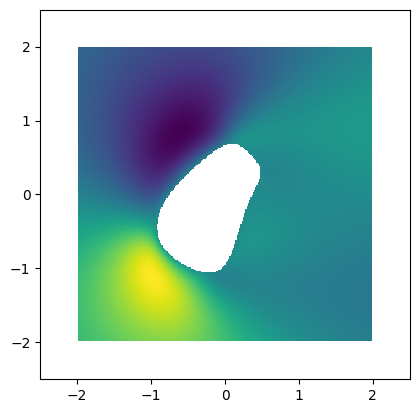

In [17]:
data = data_arr[1000]

n = 300
x = np.linspace(-2.5,2.5,n)
X,Y = np.meshgrid(x,x)
points = np.stack([X.flatten(),Y.flatten()],axis=1)
sol = data['interpSE'](points).reshape(n,n,3)
plt.imshow(sol[:,:,1],extent=[-2.5,2.5,-2.5,2.5])

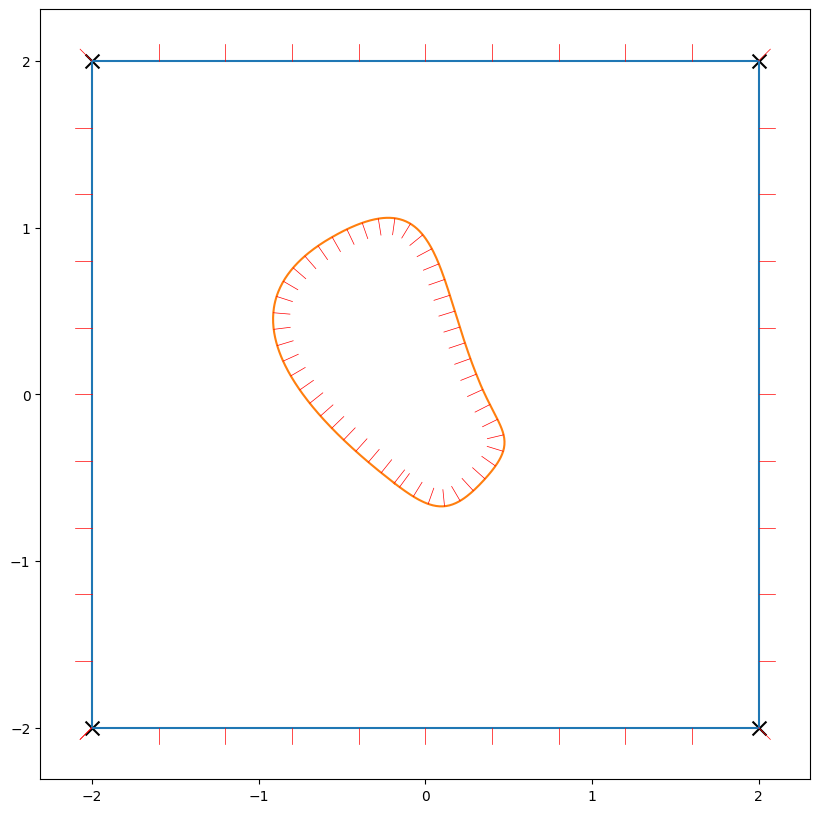

In [3]:
data = data_arr[1000]

nodes = data['nodes']
idxCurve1 = data['idxCurves'][0]
idxCurve2 = data['idxCurves'][1]
nodesB1 = nodes[idxCurve1]
normals1 = data['normalCurves'][0]
nodesB2 = nodes[idxCurve2]
normals2 = data['normalCurves'][1]
plt.figure(figsize=(10,10))
plt.plot(nodesB1[:,0],nodesB1[:,1])
k = 0.1
for i in range(nodesB1.shape[0]):
    plt.plot([nodesB1[i,0],nodesB1[i,0]+k*normals1[i,0]],[nodesB1[i,1],nodesB1[i,1]+k*normals1[i,1]],'r',linewidth=0.5)
plt.plot(nodesB2[:,0],nodesB2[:,1])
for i in range(0,nodesB2.shape[0],10):
    plt.plot([nodesB2[i,0],nodesB2[i,0]+k*normals2[i,0]],[nodesB2[i,1],nodesB2[i,1]+k*normals2[i,1]],'r',linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')

plt.scatter(nodes[data['idxCorner'],0],nodes[data['idxCorner'],1],s=100,marker='x',c='k')

In [6]:
data['nodes'][data['idxCorner']]

array([[-2., -2.],
       [ 2., -2.],
       [ 2.,  2.],
       [-2.,  2.]])

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmphnens20_/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmphnens20_/tempGeometry.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 20%] Meshing curve 2 (Nurb)
Info    : [ 40%] Meshing curve 3 (Nurb)
Info    : [ 60%] Meshing curve 4 (Nurb)
Info    : [ 80%] Meshing curve 5 (Nurb)
Info    : Done meshing 1D (Wall 0.00482404s, CPU 0.004505s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00725787s, CPU 0.00722s)
Info    : 978 nodes 1488 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmphnens20_/meshFile.msh'...
Info    : Done writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmphnens20_/meshFile.msh'


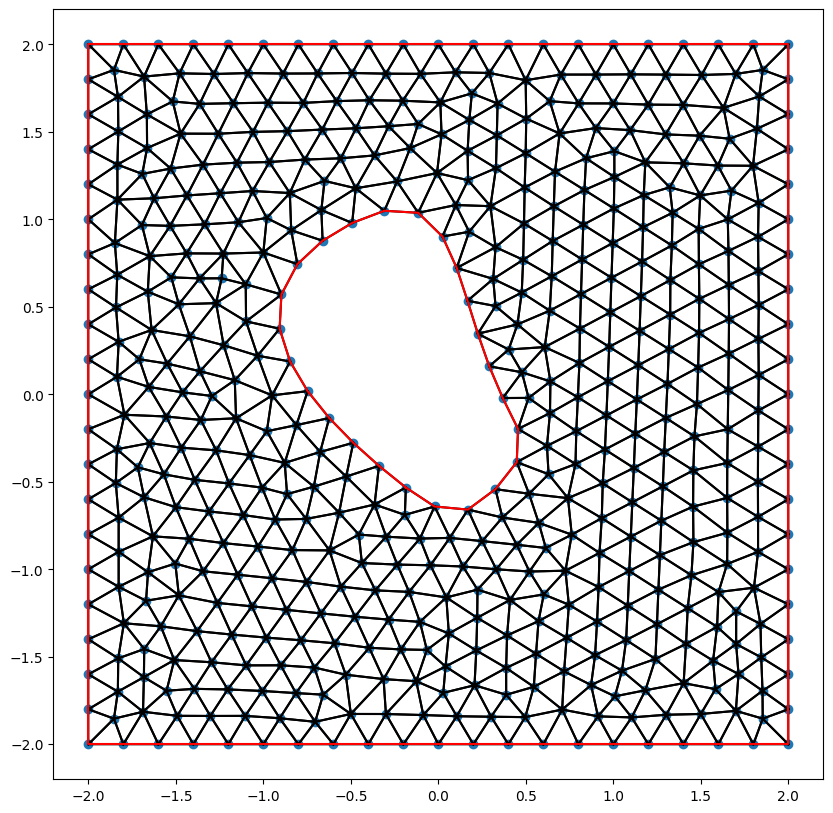

: 

In [113]:
# def GenerateGeometry(p):
#     g = cfg.Geometry()
#     for i in range(p.shape[0]):
#         g.point(list(p[i]))
#     g.spline(list(range(p.shape[0]))+[0])
#     g.surface([0])
#     return g

def GenerateGeometry2(p):
    g = cfg.Geometry()
    for i in range(p.shape[0]):
        g.point(list(p[i]))
    
    for i in range(4):
        g.line([i,(i+1)%4],marker=1)
    g.spline(list(range(4,p.shape[0]))+[4],marker=2)
    g.surface([0,1,2,3],[[4]])
    return g

def MeshSurface(g,elSize):
    mesh = cfm.GmshMesh(g)
    mesh.elType = 2       # Degrees of freedom per node.
    mesh.dofsPerNode = 1     # Factor that changes element sizes.
    mesh.elSizeFactor = elSize # Element size Factor
    nodes, edof, dofs, bdofs, elementmarkers = mesh.create()

    elements = edof-1
    boundaryNodes = [np.array(bdofs[1])-1,np.array(bdofs[2])-1]
    internalNodes = np.setdiff1d(np.arange(nodes.shape[0]), np.concatenate(boundaryNodes))
    return nodes, elements, boundaryNodes, internalNodes

def computeLengthAlongCurve(nodesB):
    dl = np.sqrt(((nodesB[1:]-nodesB[:-1])**2).sum(1))
    l = np.cumsum(dl)
    l = np.concatenate([[0],l],0)
    return l

def RemeshData(data,elSize):
    nodes = data['nodes']
    idxSquare = data['idxCorner']
    idxSpline = data['idxCurves'][1][:-1]
    nodesB = np.concatenate([ nodes[idxSquare], nodes[idxSpline]],0)

    g = GenerateGeometry2(nodesB)
    nodes,elements,idxCurves,internalNodes = MeshSurface(g,0.2)
    for i in range(len(idxCurves)):
        idxCurves[i] = np.sort(idxCurves[i])

    nodesCurves0 = nodes[idxCurves[0]]
    alpha = np.arctan2(nodesCurves0[:,1],nodesCurves0[:,0])
    idxs_sorted = np.argsort(alpha)
    idxCurves[0] = idxCurves[0][idxs_sorted]
    for i in range(len(idxCurves)):
        idxCurves[i] = np.concatenate([idxCurves[i],idxCurves[i][0:1]],0)

    nodesCurves = [nodes[idxCurves[i]] for i in range(len(idxCurves))]
    distanceCurves = [computeLengthAlongCurve(nodesCurves[i]) for i in range(len(idxCurves))]
    lengthCurves = [distanceCurves[i][-1] for i in range(len(idxCurves))]

    data_remeshed = {'nodes':nodes, 'elements':elements, 'idxCurves':idxCurves, 'internalNodes':internalNodes, \
                     'nodesCurves':nodesCurves, 'distanceCurves':distanceCurves, 'lengthCurves':lengthCurves}

    return data_remeshed

def PlotMesh(nodes, boundaryNodes, elements):
    plt.figure(figsize=(10,10))
    plt.scatter(nodes[:,0],nodes[:,1])
    if elements.shape[1] == 4:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k')
    elif elements.shape[1] == 3:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[2],el[0]],0], nodes[[el[0],el[1],el[2],el[0]],1], 'k')
    for i in range(len(boundaryNodes)):
        plt.plot(nodes[boundaryNodes[i],0],nodes[boundaryNodes[i],1],'r')
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.show()


data = data_arr[1000]

data_remeshed = RemeshData(data,0.2)

PlotMesh(data_remeshed['nodes'],data_remeshed['idxCurves'],data_remeshed['elements'])

In [109]:
data_arr[0].keys()

dict_keys(['nodes', 'elements', 'solution', 'idxCurves', 'distanceCurves', 'nodesCurves', 'lengthCurves', 'normalCurves', 'idxCorner', 'idxCurveCorner', 'idxCornerCurve', 'distaceCornerCurve', 'elementsBoundaryNodesOnly', 'areaElementsBoundaryNodesOnly', 'distance2boundary', 'elSizeNodes'])

In [96]:
idxCurves0 = np.zeros(idxCurves[0].shape[0],dtype=int)
nodesB = nodes[idxCurves[0]]

(80,)

In [106]:
data.keys()

dict_keys(['nodes', 'elements', 'solution', 'idxCurves', 'distanceCurves', 'nodesCurves', 'lengthCurves', 'normalCurves', 'idxCorner', 'idxCurveCorner', 'idxCornerCurve', 'distaceCornerCurve', 'elementsBoundaryNodesOnly', 'areaElementsBoundaryNodesOnly', 'distance2boundary', 'elSizeNodes'])